In [1]:
import geopandas as gpd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'

In [3]:
stations_df = pd.read_csv(f'{EXPORTS_DIR}/station_coords.csv')
stations_df['date'] = stations_df['date'].astype(str)
station_ids = stations_df['id'].unique()
len(station_ids)

3167

In [6]:
nyc_gdf = gpd.read_file(f'{DATA_DIR}/geo/census_tract/nyc_ct.shp')
nyc_gdf = nyc_gdf[['ct2010', 'boro_code', 'geometry']]

In [7]:
def clean_stations_df(stations_gdf):
    """Filters stations to only those within NYC."""
    gdf = gpd.sjoin(stations_gdf, nyc_gdf, how='inner', op='within')
    gdf = gdf.drop(columns=['index_right'])
    return gdf

In [8]:
def get_stations_for_date(date_string):
    """Returns a dataframe with the most recent station positions prior to the
    given YYYYMM date string."""
    # Select all stations prior to the given date string.
    stations_before_df = stations_df[stations_df['date'] < date_string]
    # Select the most recent of those stations.
    stations_recent_df = stations_before_df.groupby(by=['id']).last().reset_index()
    return stations_recent_df

In [9]:
def get_stations_gdf_for_date(date_string):
    df = get_stations_for_date(date_string)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs=CRS_LATLON)
    gdf = clean_stations_df(gdf)
    return gdf

In [10]:
def plot_stations(stations_gdf):
    fig, ax = plt.subplots(figsize=(16, 16))
    
    stations_gdf.plot(ax=ax, markersize=3, zorder=3)
    stations_xlim = plt.xlim()
    stations_ylim = plt.ylim()
    
    nyc_gdf.plot(ax=ax, color='#eee', edgecolor='#ddd', zorder=1)
    plt.xlim(stations_xlim)
    plt.ylim(stations_ylim)
    
    plt.show()

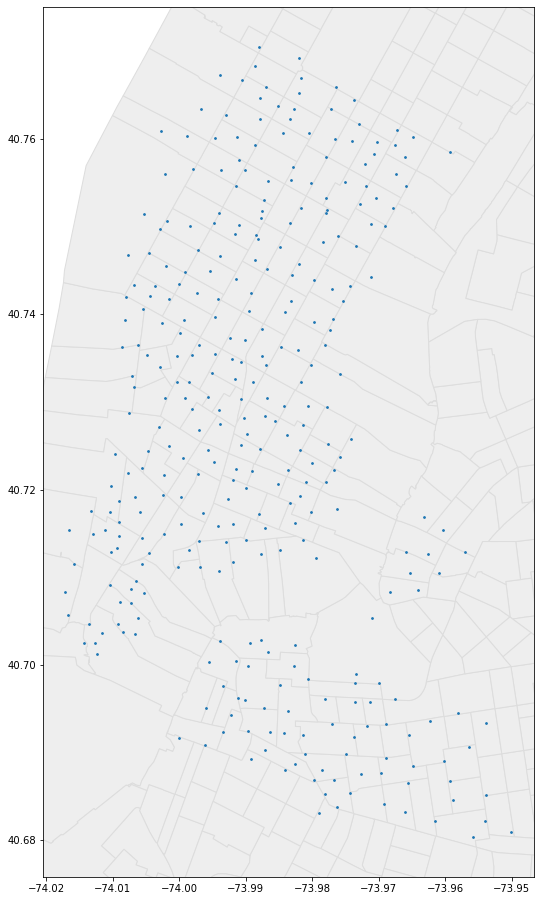

In [11]:
plot_stations(get_stations_gdf_for_date('201401'))

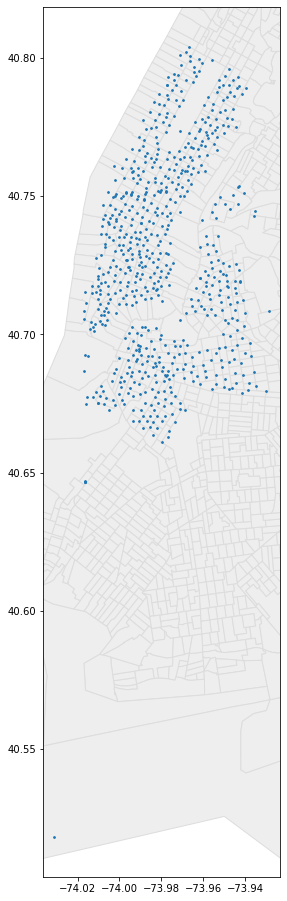

In [12]:
plot_stations(get_stations_gdf_for_date('201701'))

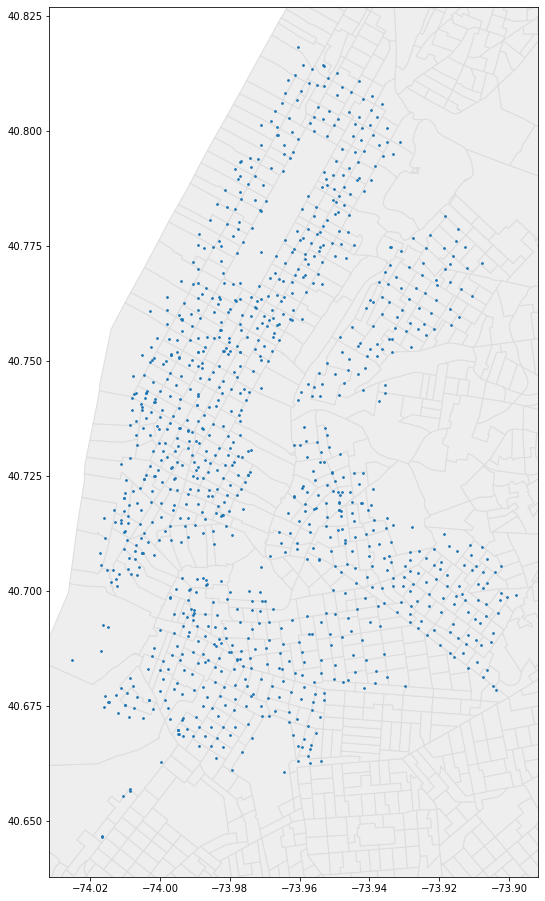

In [13]:
plot_stations(get_stations_gdf_for_date('202001'))

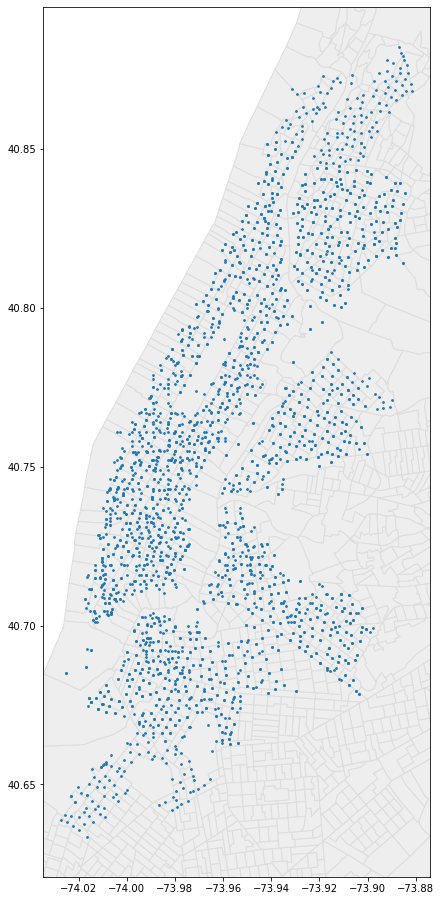

In [14]:
plot_stations(get_stations_gdf_for_date('202110'))

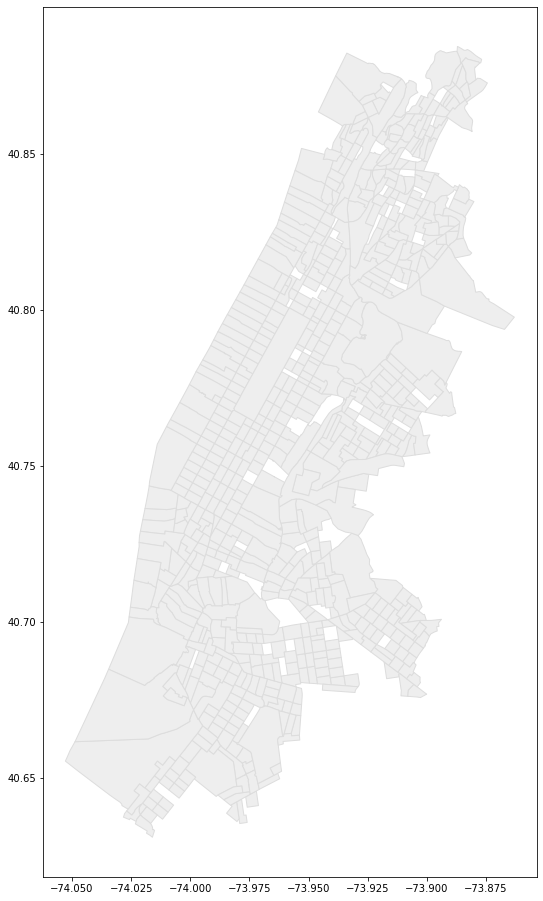

In [23]:
# The census tracts served by Citi Bike.
nyc_cb_gdf = gpd.sjoin(nyc_gdf, get_stations_gdf_for_date('202110'), how='inner', op='contains')
nyc_cb_gdf = nyc_cb_gdf[['ct2010_left', 'boro_code_left', 'geometry']].drop_duplicates()
nyc_cb_gdf = nyc_cb_gdf.rename(columns={'ct2010_left': 'ct2010', 'boro_code_left': 'boro_code'})

fig, ax = plt.subplots(figsize=(16, 16))
nyc_cb_gdf.plot(ax=ax, color='#eee', edgecolor='#ddd')
plt.show()

In [49]:
# Collect 2nd-order neighbors. Intersection seems to be creating a lot of
# polygons.
nyc_cbx_gdf = gpd.sjoin(nyc_gdf[['geometry']],
                        nyc_cb_gdf,
                        how='inner',
                        op='intersects')
nyc_cbx_gdf = nyc_cbx_gdf.drop(columns=['index_right'])
nyc_cbx_gdf = gpd.sjoin(nyc_gdf[['geometry']],
                        nyc_cbx_gdf,
                        how='inner',
                        op='intersects')
nyc_cbx_gdf = nyc_cbx_gdf.drop(columns=['index_right'])

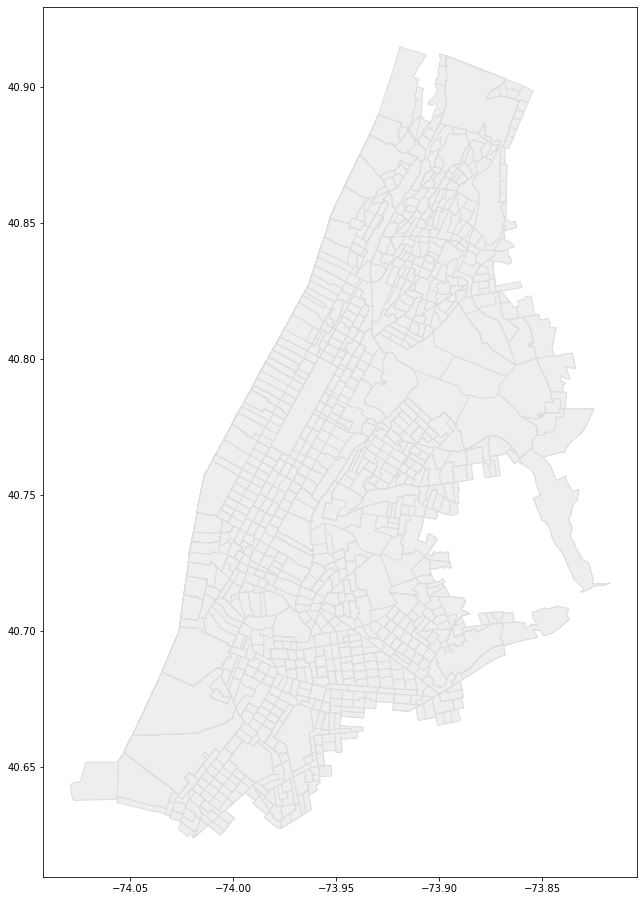

In [51]:
fig, ax = plt.subplots(figsize=(16, 16))
nyc_cbx_gdf.plot(ax=ax, color='#eee', edgecolor='#ddd')
plt.show()

In [30]:
nyc_cbx_gdf.to_file(f'{DATA_DIR}/geo/nyc_citibike.shp')